In [ ]:
! pip install findspark
! pip install -q dagshub mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import findspark
findspark.init()
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, pandas_udf,col, lower, regexp_replace, when, length, trim
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType
from pyspark.ml.feature import CountVectorizer, StringIndexer, Tokenizer, StopWordsRemover
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix
from pyspark.ml import PipelineModel, Pipeline, Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.ml.util import DefaultParamsWritable, DefaultParamsReadable
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

# Define English stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("Text Classification with PySpark").getOrCreate()

In [ ]:
#load data and split into train and test
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+|\.com\S+|youtu\.be/\S+', '', text)
    text = re.sub(r'(@|#)\w+', '', text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_text_column(df, input_col="Text", output_col="Text"):
    """
    Làm sạch văn bản trong cột DataFrame bằng các thao tác Spark native.

    Args:
        df (DataFrame): DataFrame đầu vào.
        input_col (str): Tên cột chứa văn bản gốc.
        output_col (str): Tên cột sẽ ghi văn bản đã làm sạch (có thể trùng input_col để ghi đè).

    Returns:
        DataFrame: DataFrame với cột văn bản đã được làm sạch.
    """
    return (df.withColumn(output_col, regexp_replace(col(input_col), r'https?://\S+|www\.\S+|\.com\S+|youtu\.be/\S+', ''))
              .withColumn(output_col, regexp_replace(col(output_col), r'(@|#)\w+', ''))
              .withColumn(output_col, lower(col(output_col)))
              .withColumn(output_col, regexp_replace(col(output_col), r'[^a-zA-Z\s]', ''))
              .withColumn(output_col, regexp_replace(col(output_col), r'\s+', ' '))
              )

In [ ]:
#load data
from google.colab import drive
drive.mount('/content/drive')
data = spark.read.csv('/content/drive/MyDrive/KLTN/twitter_training.csv', header=False, inferSchema=True)
data.show(10)
# Đổi tên các cột
data = data.withColumnRenamed("_c0", "Product")
data = data.withColumnRenamed("_c1", "Label")
data = data.withColumnRenamed("_c2", "Text")
# data = data.toDF("Product", "Label", "Text")
data = data.rdd.zipWithIndex().filter(lambda row: row[1] != 0).map(lambda row: row[0]).toDF(["Product", "Label", "Text"])
data.show(10)



Mounted at /content/drive
+-----------+--------+--------------------+
|        _c0|     _c1|                 _c2|
+-----------+--------+--------------------+
|    Product|   Label|                Text|
|Borderlands|Positive|I am coming to th...|
|Borderlands|Positive|im getting on bor...|
|Borderlands|Positive|im coming on bord...|
|Borderlands|Positive|im getting on bor...|
|Borderlands|Positive|im getting into b...|
|Borderlands|Positive|So I spent a few ...|
|Borderlands|Positive|So I spent a coup...|
|Borderlands|Positive|So I spent a few ...|
|Borderlands|Positive|So I spent a few ...|
+-----------+--------+--------------------+
only showing top 10 rows

+-----------+--------+--------------------+
|    Product|   Label|                Text|
+-----------+--------+--------------------+
|Borderlands|Positive|I am coming to th...|
|Borderlands|Positive|im getting on bor...|
|Borderlands|Positive|im coming on bord...|
|Borderlands|Positive|im getting on bor...|
|Borderlands|Positive|im

In [ ]:
#and prepare data
data=data.dropna(subset=['Text'])
data = clean_text_column(data, input_col="Text", output_col="Text")
data = data.withColumn("Label",
            when(col("Label") == "Negative", 0)
          .when(col("Label") == "Positive", 1)
          .when(col("Label") == "Neutral", 2)
          .when(col("Label") == "Irrelevant", 3)
          .otherwise(None)  # fallback nếu có nhãn lạ
)
data.show(10)

data = data.drop("Product")
data.show(10)
data = data.filter(length(col("Text")) > 0)
data = data.filter(col("Label").isNotNull())

+-----------+-----+--------------------+
|    Product|Label|                Text|
+-----------+-----+--------------------+
|Borderlands|    1|i am coming to th...|
|Borderlands|    1|im getting on bor...|
|Borderlands|    1|im coming on bord...|
|Borderlands|    1|im getting on bor...|
|Borderlands|    1|im getting into b...|
|Borderlands|    1|so i spent a few ...|
|Borderlands|    1|so i spent a coup...|
|Borderlands|    1|so i spent a few ...|
|Borderlands|    1|so i spent a few ...|
|Borderlands|    1| so i spent a few...|
+-----------+-----+--------------------+
only showing top 10 rows

+-----+--------------------+
|Label|                Text|
+-----+--------------------+
|    1|i am coming to th...|
|    1|im getting on bor...|
|    1|im coming on bord...|
|    1|im getting on bor...|
|    1|im getting into b...|
|    1|so i spent a few ...|
|    1|so i spent a coup...|
|    1|so i spent a few ...|
|    1|so i spent a few ...|
|    1| so i spent a few...|
+-----+----------------

In [ ]:

data = data.drop("Product")
data.show(10)

+-----+--------------------+
|Label|                Text|
+-----+--------------------+
|    1|i am coming to th...|
|    1|im getting on bor...|
|    1|im coming on bord...|
|    1|im getting on bor...|
|    1|im getting into b...|
|    1|so i spent a few ...|
|    1|so i spent a coup...|
|    1|so i spent a few ...|
|    1|so i spent a few ...|
|    1| so i spent a few...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
#split into train and test
data.show(5)
# Split data into train and test
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
data = data.filter(trim(col("Text")) != "")
# Lưu train_data và test_data thành các file CSV
# Ghi đè file CSV nếu nó đã tồn tại
train_data.write.option("header", "true").mode("overwrite").csv("/content/drive/MyDrive/KLTN/train_data.csv")
test_data.write.option("header", "true").mode("overwrite").csv("/content/drive/MyDrive/KLTN/test_data.csv")


+-----+--------------------+
|Label|                Text|
+-----+--------------------+
|    1|i am coming to th...|
|    1|im getting on bor...|
|    1|im coming on bord...|
|    1|im getting on bor...|
|    1|im getting into b...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
import mlflow
import os

os.environ['MLFLOW_TRACKING_URI']="https://dagshub.com/TranChucThien/kltn.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="TranChucThien"
os.environ["MLFLOW_TRACKING_PASSWORD"]="fc6e085ac3b8abf78e838bec58a25872e3db8679"

In [ ]:

# Bước 1: Tách từ
tokenizer = Tokenizer(inputCol="Text", outputCol="words")

# Bước 2: Loại bỏ stopwords (sử dụng danh sách NLTK)
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=stop_words)

# Bước 3: Vector hóa văn bản
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

# Bước 4: Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="Label", maxIter=20)

# Bước 5: Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, lr])
# Huấn luyện mô hình
model1 = pipeline.fit(train_data)
# Lưu mô hình
model1.write().overwrite().save("/content/drive/MyDrive/KLTN/models/logistic_regression_model_count_vector")

mlflow.set_tracking_uri("https://dagshub.com/TranChucThien/kltn.mlflow")
with mlflow.start_run(run_name="LogisticRegression_IDF_TF_Model") as run:
  # signature=infer_signature(X_train,y_train)
  mlflow.spark.log_model(model1, artifact_path="spark-model")
  model_uri = f"runs:/{run.info.run_id}/spark-model"
  registered_model = mlflow.register_model(model_uri=model_uri, name="LogisticRegression_TFIDF_Model")

  # Ghi log tham số
  mlflow.log_param("maxIter", 20)
  mlflow.log_param("numFeatures", 10000)



2025/04/22 10:43:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression_TFIDF_Model' already exists. Creating a new version of this model...
2025/04/22 10:44:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_TFIDF_Model, version 2
Created version '2' of model 'LogisticRegression_TFIDF_Model'.


🏃 View run LogisticRegression_IDF_TF_Model at: https://dagshub.com/TranChucThien/kltn.mlflow/#/experiments/0/runs/da8147c3e0b2429cb939bf364db46265
🧪 View experiment at: https://dagshub.com/TranChucThien/kltn.mlflow/#/experiments/0


In [ ]:
# Bước 1: Tách từ
tokenizer = Tokenizer(inputCol="Text", outputCol="Words")

# Bước 2: Loại bỏ stopwords (sử dụng danh sách NLTK)
remover = StopWordsRemover(inputCol="Words", outputCol="FilteredWords", stopWords=stop_words)

# Bước 3: HashingTF để vector hóa
hashingTF = HashingTF(inputCol="FilteredWords", outputCol="RawFeatures", numFeatures=10000)

# Bước 4: Chuẩn hóa với IDF
idf = IDF(inputCol="RawFeatures", outputCol="features")

# Bước 5: Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="Label", maxIter=20)

# Tạo pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])

# Huấn luyện mô hình
model2 = pipeline.fit(train_data)
# Lưu mô hình, ghi đè nếu thư mục đã tồn tại
model2.write().overwrite().save("/content/drive/MyDrive/KLTN/models/logistic_regression_model_idftf")


In [ ]:
# Dự đoán trên tập test
prediction1 = model1.transform(test_data)
prediction2 = model2.transform(test_data)

# # Hiển thị kết quả mẫu
prediction2.select("Text", "Label", "prediction", "probability").show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+--------------------------------------------------------------------------------------+
|Text                                                                                                                                                                                                                                                                                                   |Label|prediction|probability                                                                           |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Đánh giá độ chính xác
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")

# accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
# precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
# recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
# f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# print(f"Accuracy:  {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall:    {recall:.4f}")
# print(f"F1-score:  {f1:.4f}")
def evaluate_model(predictions):
    evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
evaluate_model(prediction1)
evaluate_model(prediction2)

Accuracy:  0.8251
Precision: 0.8259
Recall:    0.8251
F1-score:  0.8250
Accuracy:  0.8251
Precision: 0.8259
Recall:    0.8251
F1-score:  0.8250
Accuracy:  0.7216
Precision: 0.7215
Recall:    0.7216
F1-score:  0.7213


Accuracy:  0.9206
Precision: 0.9220
Recall:    0.9206
F1-score:  0.9208

Classification Report:
              precision    recall  f1-score   support

           0     0.9367    0.9248    0.9307      4386
           1     0.8746    0.9406    0.9064      4139
           2     0.9443    0.9121    0.9279      3606
           3     0.9415    0.8939    0.9171      2630

    accuracy                         0.9206     14761
   macro avg     0.9243    0.9178    0.9205     14761
weighted avg     0.9220    0.9206    0.9208     14761



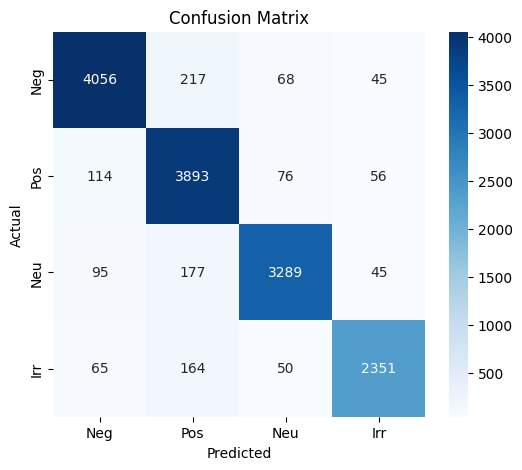

In [ ]:
loaded_model = PipelineModel.load("/content/drive/MyDrive/KLTN/logistic_regression_model")
# Dự đoán với test_data dùng mô hình đã load
predictions = loaded_model.transform(test_data)
# Đánh giá với evaluator của Spark
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Dùng sklearn để vẽ confusion matrix
y_true = predictions.select("Label").toPandas()
y_pred = predictions.select("prediction").toPandas()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Neg", "Pos", "Neu", "Irr"],
            yticklabels=["Neg", "Pos", "Neu", "Irr"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from pyspark.sql import Row
from pyspark.sql.functions import when, col
import pandas as pd

# 1. Tạo DataFrame Spark từ 5 đoạn văn bản mới
new_texts = [
    "I absolutely love this phone! The camera is amazing and the battery lasts all day.",
    "The customer service from this brand is terrible. My issue has not been resolved for weeks.",
    "This laptop is solid and reliable, but it's a bit expensive for the performance it offers.",
    "I had a terrible experience with this brand. Their products broke down after just a few months.",
    "The quality of the shoes from this brand has improved significantly. They are comfortable and durable."
]

# 2. Tải mô hình đã huấn luyện
loaded_model = PipelineModel.load("/content/drive/MyDrive/KLTN/logistic_regression_model")

# Tạo DataFrame từ danh sách văn bản mới
new_data = [Row(Text=text) for text in new_texts]
new_df = spark.createDataFrame(new_data)

# 3. Dự đoán với mô hình đã tải
predictions_new = loaded_model.transform(new_df)

# 4. Ánh xạ các nhãn prediction thành các giá trị tương ứng
predictions_new_mapped = predictions_new.withColumn(
    "Label",
    when(col("prediction") == 0, "Negative")
    .when(col("prediction") == 1, "Positive")
    .when(col("prediction") == 2, "Neutral")
    .when(col("prediction") == 3, "Irrelevant")
    .otherwise("Unknown")  # fallback nếu có nhãn lạ
)

# 5. Hiển thị kết quả dự đoán với nhãn ánh xạ
predictions_new_mapped.select("Text", "prediction", "Label").show(truncate=False)

# Nếu bạn muốn lưu lại các dự đoán vào DataFrame và sử dụng sau này:
predictions_df = predictions_new_mapped.select("Text", "prediction", "Label").toPandas()
print(predictions_df)


+------------------------------------------------------------------------------------------------------+----------+--------+
|Text                                                                                                  |prediction|Label   |
+------------------------------------------------------------------------------------------------------+----------+--------+
|I absolutely love this phone! The camera is amazing and the battery lasts all day.                    |1.0       |Positive|
|The customer service from this brand is terrible. My issue has not been resolved for weeks.           |0.0       |Negative|
|This laptop is solid and reliable, but it's a bit expensive for the performance it offers.            |0.0       |Negative|
|I had a terrible experience with this brand. Their products broke down after just a few months.       |0.0       |Negative|
|The quality of the shoes from this brand has improved significantly. They are comfortable and durable.|2.0       |Neutral |


In [ ]:
import mlflow
import mlflow.spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("Test Spark Model") \
    .getOrCreate()

# Thiết lập URI của MLflow tại Dagshub
mlflow.set_tracking_uri("https://dagshub.com/TranChucThien/kltn.mlflow")

# Tải mô hình đã đăng ký
model_name = "LogisticRegression_TFIDF_Model"
model_version = 1  # Thay đổi nếu bạn muốn tải một version khác
model_uri = f"models:/{model_name}/{model_version}"

# Tải mô hình
loaded_model = mlflow.spark.load_model(model_uri)

# Dự đoán trên dữ liệu mới
new_texts = [
    "I absolutely love this phone! The camera is amazing and the battery lasts all day.",
    "The customer service from this brand is terrible. My issue has not been resolved for weeks.",
    "This laptop is solid and reliable, but it's a bit expensive for the performance it offers.",
    "I had a terrible experience with this brand. Their products broke down after just a few months.",
    "The quality of the shoes from this brand has improved significantly. They are comfortable and durable."
]

# Tạo DataFrame Spark từ danh sách văn bản mới
new_data = [Row(Text=text) for text in new_texts]
new_df = spark.createDataFrame(new_data)

# Dự đoán với mô hình đã tải
predictions_new = loaded_model.transform(new_df)

# Ánh xạ các nhãn prediction thành các giá trị tương ứng
predictions_new_mapped = predictions_new.withColumn(
    "Label",
    when(col("prediction") == 0, "Negative")
    .when(col("prediction") == 1, "Positive")
    .when(col("prediction") == 2, "Neutral")
    .when(col("prediction") == 3, "Irrelevant")
    .otherwise("Unknown")  # fallback nếu có nhãn lạ
)

# Hiển thị kết quả dự đoán với nhãn ánh xạ
predictions_new_mapped.select("Text", "prediction", "Label").show(truncate=False)

# Nếu bạn muốn lưu lại các dự đoán vào DataFrame và sử dụng sau này:
predictions_df = predictions_new_mapped.select("Text", "prediction", "Label").toPandas()
print(predictions_df)


2025/04/21 04:44:33 INFO mlflow.spark: URI 'models:/LogisticRegression_TFIDF_Model/1/sparkml' does not point to the current DFS.
2025/04/21 04:44:33 INFO mlflow.spark: File 'models:/LogisticRegression_TFIDF_Model/1/sparkml' not found on DFS. Will attempt to upload the file.


+------------------------------------------------------------------------------------------------------+----------+--------+
|Text                                                                                                  |prediction|Label   |
+------------------------------------------------------------------------------------------------------+----------+--------+
|I absolutely love this phone! The camera is amazing and the battery lasts all day.                    |1.0       |Positive|
|The customer service from this brand is terrible. My issue has not been resolved for weeks.           |0.0       |Negative|
|This laptop is solid and reliable, but it's a bit expensive for the performance it offers.            |0.0       |Negative|
|I had a terrible experience with this brand. Their products broke down after just a few months.       |0.0       |Negative|
|The quality of the shoes from this brand has improved significantly. They are comfortable and durable.|2.0       |Neutral |


In [ ]:
def evaluate_model(predictions, model_name=""):
    evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

    # Log các metric vào MLflow
    # mlflow.log_metric(f"{model_name}accuracy", accuracy)
    # mlflow.log_metric(f"{model_name}_precision", precision)
    # mlflow.log_metric(f"{model_name}_recall", recall)
    # mlflow.log_metric(f"{model_name}_f1_score", f1)
    mlflow.log_metric(f"accuracy", accuracy)
    mlflow.log_metric(f"precision", precision)
    mlflow.log_metric(f"recall", recall)
    mlflow.log_metric(f"f1_score", f1)



In [ ]:
with mlflow.start_run(run_name="LogisticRegression_IDF_TF_Model") as run:
    model2 = pipeline.fit(train_data)
    prediction2 = model2.transform(test_data)

    mlflow.spark.log_model(
        spark_model=model2,
        artifact_path="spark-model",
        registered_model_name="LogReg_TFIDF"
    )

    mlflow.log_param("maxIter", 20)
    mlflow.log_param("numFeatures", 10000)

    evaluate_model(prediction2, model_name="idf_tf")

with mlflow.start_run(run_name="LogisticRegression_CountVector_Model") as run:
    model1 = pipeline.fit(train_data)
    prediction1 = model1.transform(test_data)


    mlflow.spark.log_model(
        spark_model=model1,
        artifact_path="spark-model",
        registered_model_name="LogReg_CountVector"
    )

    mlflow.log_param("maxIter", 20)

    evaluate_model(prediction1, model_name="count_vector")


2025/04/22 10:57:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LogReg_TFIDF'.
2025/04/22 10:58:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogReg_TFIDF, version 1
Created version '1' of model 'LogReg_TFIDF'.


Accuracy:  0.7340
Precision: 0.7343
Recall:    0.7340
F1-score:  0.7335
🏃 View run LogisticRegression_IDF_TF_Model at: https://dagshub.com/TranChucThien/kltn.mlflow/#/experiments/0/runs/bf7196d5adf64d6aafaee6df5b207077
🧪 View experiment at: https://dagshub.com/TranChucThien/kltn.mlflow/#/experiments/0


2025/04/22 10:59:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LogReg_CountVector'.
2025/04/22 11:00:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogReg_CountVector, version 1
Created version '1' of model 'LogReg_CountVector'.


Accuracy:  0.7340
Precision: 0.7343
Recall:    0.7340
F1-score:  0.7335
🏃 View run LogisticRegression_CountVector_Model at: https://dagshub.com/TranChucThien/kltn.mlflow/#/experiments/0/runs/945402e5cc7d4d54825c9889c671c117
🧪 View experiment at: https://dagshub.com/TranChucThien/kltn.mlflow/#/experiments/0
